# Week 3 - Attitude Control of States and Rates

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


## CC1, Q4

In [3]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [4]:
def q4_controller_u(
    sigma_BN: np.ndarray,
    omega_BN: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    sigma_RN: np.ndarray | None = None,
    omega_RN: np.ndarray | None = None,
    omega_dot_RN: np.ndarray | None = None,
    L: np.ndarray | None = None,
) -> np.ndarray:
    """
    Compute body-frame control torque for the Q4 nonlinear attitude controller.

    Implements the tracking-form control law:
        u = -K*sigma_BR - P*omega_BR
            + I*(omega_dot_RN - omega_BN × omega_RN)
            + omega_BN × (I*omega_BN) - L

    Defaults correspond to the regulator case (R = N, L = 0).

    Parameters
    ----------
    sigma_BN : np.ndarray
        Body attitude relative to inertial frame (MRPs).
    omega_BN : np.ndarray
        Body angular velocity relative to inertial frame (rad/s).
    I : np.ndarray
        Spacecraft inertia matrix (3×3, body frame).
    K : float
        Attitude proportional gain.
    P : float
        Rate damping gain.
    sigma_RN, omega_RN, omega_dot_RN : np.ndarray or None
        Reference attitude, angular rate, and angular acceleration.
    L : np.ndarray or None
        Disturbance torque (body frame).

    Returns
    -------
    u : np.ndarray
        Control torque expressed in the body frame.
    """
    if sigma_RN is None:
        sigma_RN = np.zeros(3)
    if omega_RN is None:
        omega_RN = np.zeros(3)
    if omega_dot_RN is None:
        omega_dot_RN = np.zeros(3)
    if L is None:
        L = np.zeros(3)
        
    # Finding sigma_BR is sigma_BN for q4
    sigma_BR = sigma_BN
    
    # Finding omega_BR (angular rates are alr in body frame)
    omega_BR = omega_BN - omega_RN

    u = -(K * sigma_BR) - (P * omega_BR) + (I @ (omega_dot_RN - np.cross(omega_BN, omega_RN))) + np.cross(omega_BN, I @ omega_BN) - L
    
    return u

In [5]:
def q4_lyapunov_V(
    sigma_BN: np.ndarray,
    omega_BN: np.ndarray,
    I: np.ndarray,
    K: float,
) -> float:
    """
    Evaluate the Lyapunov candidate for the Q4 MRP attitude controller.

    Computes:
        V = 1/2 * omega_BN^T * I * omega_BN
            + 2K * ln(1 + sigma_BN^T * sigma_BN)

    Parameters
    ----------
    sigma_BN : np.ndarray
        Body attitude relative to inertial frame, expressed as MRPs (3,).
    omega_BN : np.ndarray
        Body angular velocity relative to inertial frame (rad/s, 3,).
    I : np.ndarray
        Spacecraft inertia matrix expressed in the body frame (3×3).
    K : float
        Attitude proportional gain.

    Returns
    -------
    V : float
        Scalar Lyapunov function value.
    """
    V = 0.5 * omega_BN @ (I @ omega_BN) + 2.0 * K * np.log(1.0 + sigma_BN @ sigma_BN)
    return V

In [6]:
def q4_xdot(
    t: float,
    x: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
) -> np.ndarray:
    """
    Compute the closed-loop state derivative xdot for Coursera Q4 (MRP attitude regulator).

    Defines the ODE used by the integrator:
        x = [sigma_BN, omega_BN]
        xdot = [sigma_dot_BN, omega_dot_BN]

    where sigma_dot is obtained from MRP kinematics and omega_dot from Euler rigid-body
    dynamics driven by the Q4 control torque u = q4_controller_u(...). Regulator
    assumptions (R = N, L = 0) are applied via the controller defaults.

    Parameters
    ----------
    t : float
        Time (included for ODE solver compatibility; not used explicitly).
    x : np.ndarray
        State vector [sigma_BN (3,), omega_BN (3,)] with omega expressed in the body frame.
    I : np.ndarray
        Spacecraft inertia matrix (3×3, body frame).
    K : float
        Attitude proportional gain.
    P : float
        Rate damping gain.

    Returns
    -------
    xdot : np.ndarray
        Time derivative [sigma_dot_BN (3,), omega_dot_BN (3,)].
    """
    # unpack
    sigma_BN = mrp_shadow(x[0:3])
    omega_BN = x[3:6]

    # controller torque (defaults implement regulator assumptions)
    u = q4_controller_u(sigma_BN, omega_BN, I, K, P)

    # rigid-body dynamics: I*omega_dot = u - omega x (I*omega)
    omega_dot = np.linalg.solve(I, u - np.cross(omega_BN, I @ omega_BN))

    # MRP kinematics: sigma_dot = 1/4 * B(sigma) * omega
    B = ak.Bmat_MRP(sigma_BN)
    sigma_dot = 0.25 * (B @ omega_BN)

    xdot = np.hstack((sigma_dot, omega_dot))

    return xdot

In [7]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next


In [8]:
def simulate_q4():
    """
    Simulate Coursera Q4 nonlinear attitude regulator using fixed-step RK4 propagation.

    This simulation enforces MRP shadow switching as a discrete state reset after each
    timestep dt (hybrid propagation). Control torque u and Lyapunov candidate V are
    logged using the single-source functions q4_controller_u(...) and q4_lyapunov_V(...).

    Returns
    -------
    results : dict
        Dictionary containing:
        - 't'      : time history (N,)
        - 'x'      : state history [sigma_BN, omega_BN] (N,6)
        - 'u'      : control torque history (N,3)
        - 'V'      : Lyapunov history (N,)
        - 'params' : {'I': I, 'K': K, 'P': P}
    """
    # --- spacecraft parameters ---
    I = np.diag([100.0, 75.0, 80.0])   # kg*m^2
    K = 5.0                            # N*m
    P = 10.0                           # N*m*s

    # --- initial conditions ---
    sigma0 = np.array([0.1, 0.2, -0.1])       # MRPs
    omega0 = np.deg2rad([30.0, 10.0, -20.0])  # rad/s
    x0 = np.hstack((sigma0, omega0))

    # --- time settings ---
    t0 = 0.0
    tf = 120.0
    dt = 0.01
    t_hist = np.arange(t0, tf + dt, dt)
    N = len(t_hist)

    # --- allocate histories ---
    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))
    V_hist = np.zeros(N)

    # --- initialize (enforce short MRP set once) ---
    x = x0.copy()
    x[0:3] = mrp_shadow(x[0:3])
    x_hist[0] = x

    # --- fixed-step integrate with RK4 + shadow reset ---
    for k in range(N - 1):
        t = t_hist[k]

        # log at t_k using single-source functions
        sigma = x[0:3]
        omega = x[3:6]
        u_hist[k] = q4_controller_u(sigma, omega, I, K, P)
        V_hist[k] = q4_lyapunov_V(sigma, omega, I, K)

        # RK4 step: x_{k+1} = x_k + ...
        x_next = rk4_step(q4_xdot, t, x, dt, I, K, P)

        # discrete shadow-set reset (hybrid step)
        x_next[0:3] = mrp_shadow(x_next[0:3])

        # store and advance
        x = x_next
        x_hist[k + 1] = x

    # --- final logs at t_f ---
    sigma = x_hist[-1, 0:3]
    omega = x_hist[-1, 3:6]
    u_hist[-1] = q4_controller_u(sigma, omega, I, K, P)
    V_hist[-1] = q4_lyapunov_V(sigma, omega, I, K)

    # --- quiz output at t = 30 s ---
    idx_30 = int(30.0 / dt)
    print(f"Q4: ||sigma_BN|| at t=30 s = {np.linalg.norm(x_hist[idx_30,0:3]):.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "u": u_hist,
        "V": V_hist,
        "params": {"I": I, "K": K, "P": P},
    } 
    return results



q4_sim_result = simulate_q4()
q4_sim_result

Q4: ||sigma_BN|| at t=30 s = 0.194750611871007


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317420e-01,
          5.23025206e-01,  1.74166977e-01, -3.48566918e-01],
        [ 1.02058633e-01,  2.00886941e-01, -1.02634236e-01,
          5.22451696e-01,  1.73801221e-01, -3.48067787e-01],
        ...,
        [-1.01918013e-03,  3.56154752e-05,  5.41532586e-04,
         -3.76229175e-04,  4.65625211e-05, -8.66542380e-05],
        [-1.02011974e-03,  3.57303144e-05,  5.41315494e-04,
         -3.75343563e-04,  4.64767130e-05, -8.68841665e-05],
        [-1.02105713e-03,  3.58449405e-05,  5.41097828e-04,
         -3.74458368e-04,  4.63909428e-05, -8.71136720e-05]]),
 'u': array([[-6.04060518e+00, -6.40073829e+00,  1.70602786e+00],
        [-6.03894394e+00, -6.39007678e+00,  1.71491330e+00],
        [-6.03728315e+00, -

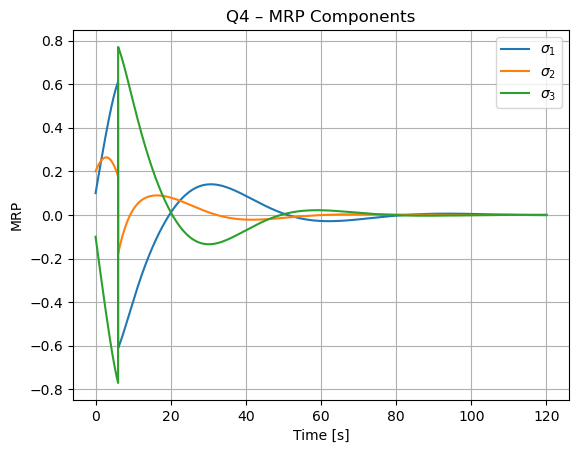

In [9]:
t = q4_sim_result['t']
x = q4_sim_result['x']
u = q4_sim_result['u']
V = q4_sim_result['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q4 – MRP Components")
plt.legend()
plt.show()

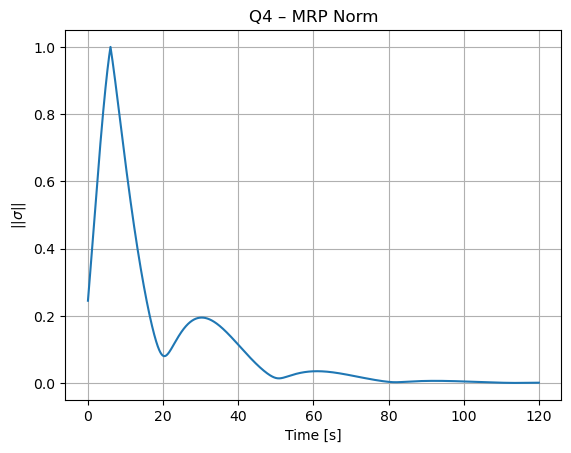

In [10]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma||$")
plt.title("Q4 – MRP Norm")
plt.show()


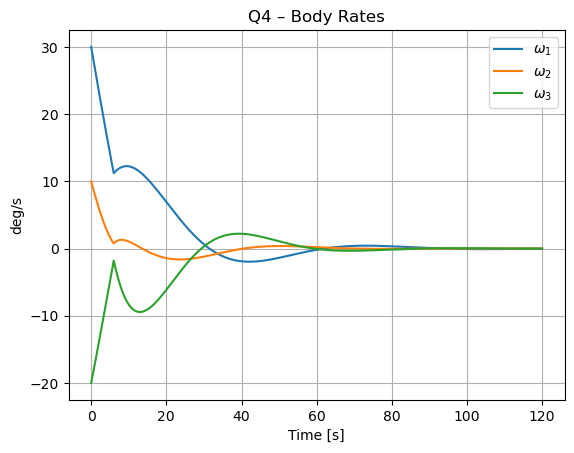

In [11]:
plt.figure()
plt.plot(t, omega_deg[:, 0], label=r'$\omega_1$')
plt.plot(t, omega_deg[:, 1], label=r'$\omega_2$')
plt.plot(t, omega_deg[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q4 – Body Rates")
plt.legend()
plt.show()

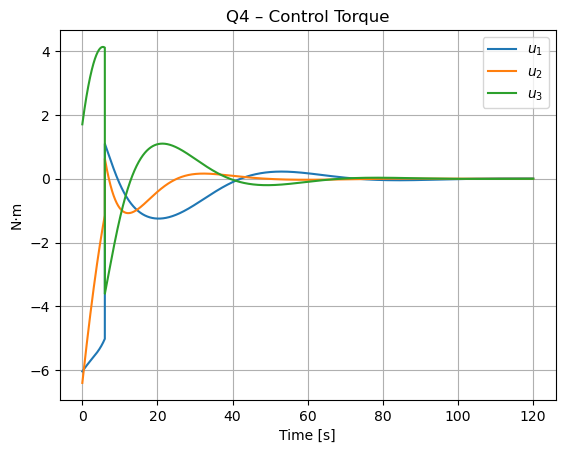

In [12]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("N·m")
plt.title("Q4 – Control Torque")
plt.legend()
plt.show()


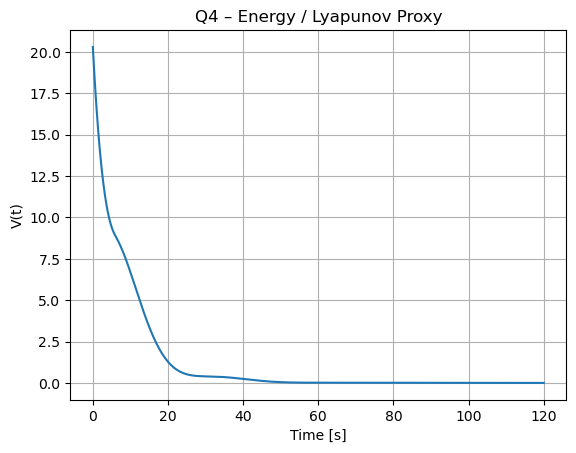

In [13]:
plt.figure()
plt.plot(t, V)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("V(t)")
plt.title("Q4 – Energy / Lyapunov Proxy")
plt.show()


## CC1, Q5

In [14]:
def q5_sigma_RN(t: float, f: float = 0.05) -> np.ndarray:
    """
    Reference attitude MRPs σ_R/N(t) for Q5 tracking case.

    Inputs:
        t: time [s]
        f: reference frequency [rad/s]

    Output:
        sigma_RN: (3,) MRPs of reference frame R relative to inertial N.
    """
    sigma_RN = np.array(
        [
            0.2 * np.sin(f * t),
            0.3 * np.cos(f * t),
            -0.3 * np.sin(f * t),
        ],
        dtype=float,
    )
    return sigma_RN


def q5_sigma_RN_dot(t: float, f: float = 0.05) -> np.ndarray:
    """
    Time derivative of reference MRPs σ̇_R/N(t) for Q5 tracking case.

    Inputs:
        t: time [s]
        f: reference frequency [rad/s]

    Output:
        sigma_RN_dot: (3,) time derivative of MRPs [1/s].
    """
    sigma_RN_dot = np.array(
        [
            0.2 * f * np.cos(f * t),
            -0.3 * f * np.sin(f * t),
            -0.3 * f * np.cos(f * t),
        ],
        dtype=float,
    )
    return sigma_RN_dot

In [15]:
def q5_omega_RN_R(t: float, f: float = 0.05) -> np.ndarray:
    """
    Reference angular rate ω_R/N expressed in the reference frame R.

    Uses the MRP kinematic relation: σ̇ = (1/4) B(σ) ω  =>  ω = 4 B(σ)^{-1} σ̇.

    Inputs:
        t: time [s]
        f: reference frequency [rad/s]

    Output:
        omega_RN_R: (3,) angular velocity of R relative to N, expressed in R [rad/s].
    """
    sigma_RN = q5_sigma_RN(t, f)
    sigma_RN_dot = q5_sigma_RN_dot(t, f)
    BInv_RN = ak.BInvmat_MRP(sigma_RN)

    omega_RN_R = 4.0 * (BInv_RN @ sigma_RN_dot)
    return omega_RN_R

In [16]:
def q5_omega_RN_dot_R(t: float, f: float = 0.05, eps: float = 1e-5) -> np.ndarray:
    """
    Time derivative of reference angular rate ω̇_R/N expressed in R, via centered difference.

    Inputs:
        t: time [s]
        f: reference frequency [rad/s]
        eps: finite-difference step [s]

    Output:
        omega_RN_dot_R: (3,) angular acceleration of R relative to N, expressed in R [rad/s^2].
    """
    omega_plus_R = q5_omega_RN_R(t + eps, f)
    omega_minus_R = q5_omega_RN_R(t - eps, f)

    omega_RN_dot_R = (omega_plus_R - omega_minus_R) / (2.0 * eps)
    return omega_RN_dot_R

In [17]:
def mrp_error_BR(sigma_BN: np.ndarray, sigma_RN: np.ndarray) -> np.ndarray:
    """
    Attitude tracking error MRPs σ_B/R from σ_B/N and σ_R/N.

    Inputs:
        sigma_BN: (3,) body MRPs relative to inertial N
        sigma_RN: (3,) reference MRPs relative to inertial N

    Output:
        sigma_BR: (3,) MRPs of body B relative to reference R (shadow-set enforced).
    """
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)

    C_BR = C_BN @ C_RN.T
    sigma_BR = ak.DCM_to_MRP(C_BR)
    sigma_BR = mrp_shadow(sigma_BR)

    return sigma_BR

In [18]:
def omega_error_BR_B(
    sigma_BN: np.ndarray,
    sigma_RN: np.ndarray,
    omega_BN_B: np.ndarray,
    omega_RN_R: np.ndarray,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Rate tracking error ω_B/R expressed in B, plus useful intermediates.

    Inputs:
        sigma_BN: (3,) MRPs of B relative to N
        sigma_RN: (3,) MRPs of R relative to N
        omega_BN_B: (3,) ω_B/N expressed in B [rad/s]
        omega_RN_R: (3,) ω_R/N expressed in R [rad/s]

    Outputs:
        omega_BR_B: (3,) ω_B/R expressed in B [rad/s]
        omega_RN_B: (3,) ω_R/N expressed in B [rad/s]
        C_BR: (3,3) DCM from R to B.
    """
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    return omega_BR_B, omega_RN_B, C_BR

In [19]:
def q5_controller_u(
    t: float,
    sigma_BN: np.ndarray,
    omega_BN_B: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    f: float = 0.05,
    L: np.ndarray | None = None,
) -> np.ndarray:
    """
    Q5 globally asymptotically stabilizing tracking controller torque u.

    Inputs:
        t: time [s]
        sigma_BN: (3,) MRPs of B relative to N
        omega_BN_B: (3,) ω_B/N expressed in B [rad/s]
        I: (3,3) inertia matrix in B [kg*m^2]
        K: attitude gain [N*m]
        P: rate gain [N*m*s]
        f: reference frequency [rad/s]
        L: (3,) external disturbance torque in B [N*m] (defaults to zero)

    Output:
        u: (3,) control torque in B [N*m].
    """
    L_B = np.zeros(3) if L is None else L

    sigma_RN = q5_sigma_RN(t, f)
    sigma_BR = mrp_error_BR(sigma_BN, sigma_RN)

    omega_RN_R = q5_omega_RN_R(t, f)
    omega_RN_dot_R = q5_omega_RN_dot_R(t, f)

    omega_BR_B, omega_RN_B, C_BR = omega_error_BR_B(
        sigma_BN, sigma_RN, omega_BN_B, omega_RN_R
    )
    omega_RN_dot_B = C_BR @ omega_RN_dot_R

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_RN_dot_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )
    return u_B

In [20]:
def q5_lyapunov_V(
    sigma_BR: np.ndarray,
    omega_BR_B: np.ndarray,
    I: np.ndarray,
    K: float,
) -> float:
    """
    Lyapunov candidate used for Q5 tracking law verification.

    Inputs:
        sigma_BR: (3,) MRPs of B relative to R
        omega_BR_B: (3,) ω_B/R expressed in B [rad/s]
        I: (3,3) inertia matrix [kg*m^2]
        K: attitude gain [N*m]

    Output:
        V: scalar Lyapunov value.
    """
    V = 0.5 * (omega_BR_B @ (I @ omega_BR_B)) + 2.0 * K * np.log(
        1.0 + (sigma_BR @ sigma_BR)
    )
    return V

In [21]:
def q5_xdot(
    t: float,
    x: np.ndarray,
    I: np.ndarray,
    K: float,
    P: float,
    f: float = 0.05,
) -> np.ndarray:
    """
    Q5 closed-loop state derivative for integration.

    State convention:
        x = [sigma_BN (3), omega_BN_B (3)]

    Inputs:
        t: time [s]
        x: (6,) state vector
        I: (3,3) inertia matrix [kg*m^2]
        K: attitude gain [N*m]
        P: rate gain [N*m*s]
        f: reference frequency [rad/s]

    Output:
        x_dot: (6,) time derivative of state.
    """
    sigma_BN = x[0:3]
    omega_BN_B = x[3:6]

    u_B = q5_controller_u(t, sigma_BN, omega_BN_B, I, K, P, f=f)

    omega_BN_dot_B = np.linalg.solve(I, u_B - np.cross(omega_BN_B, I @ omega_BN_B))

    B_BN = ak.Bmat_MRP(sigma_BN)
    sigma_BN_dot = 0.25 * (B_BN @ omega_BN_B)

    x_dot = np.hstack((sigma_BN_dot, omega_BN_dot_B))
    return x_dot


In [22]:
def simulate_q5() -> dict[str, np.ndarray | dict[str, float | np.ndarray]]:
    """
    Run Q5 tracking simulation and log state, control, Lyapunov, and tracking error histories.

    Output:
        results: dict with keys:
            't'        : (N,) time stamps [s]
            'x'        : (N,6) state history [sigma_BN, omega_BN_B]
            'u'        : (N,3) control torque history [N*m]
            'V'        : (N,) Lyapunov history
            'err'      : (N,) ||sigma_B/R|| tracking error norm history
            'sigma_BR' : (N,3) MRPs of B relative to R (shadow enforced)
            'omega_BR' : (N,3) ω_B/R expressed in B [rad/s]
            'params'   : dict of simulation parameters
    """
    I = np.diag([100.0, 75.0, 80.0])
    K = 5.0
    P = 10.0
    f = 0.05

    sigma0_BN = np.array([0.1, 0.2, -0.1], dtype=float)
    omega0_BN_B = np.deg2rad(np.array([30.0, 10.0, -20.0], dtype=float))

    x = np.hstack((sigma0_BN, omega0_BN_B))
    x[0:3] = mrp_shadow(x[0:3])

    t0, tf, dt = 0.0, 120.0, 0.01
    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    x_hist = np.zeros((N, 6))
    u_hist = np.zeros((N, 3))
    V_hist = np.zeros(N)
    err_hist = np.zeros(N)

    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))

    x_hist[0] = x

    for k in range(N):
        t = t_hist[k]
        sigma_BN = x[0:3]
        omega_BN_B = x[3:6]

        sigma_RN = q5_sigma_RN(t, f)
        sigma_BR = mrp_error_BR(sigma_BN, sigma_RN)

        omega_RN_R = q5_omega_RN_R(t, f)
        omega_BR_B, _, _ = omega_error_BR_B(sigma_BN, sigma_RN, omega_BN_B, omega_RN_R)

        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B
        err_hist[k] = np.linalg.norm(sigma_BR)

        u_hist[k] = q5_controller_u(t, sigma_BN, omega_BN_B, I, K, P, f=f)
        V_hist[k] = q5_lyapunov_V(sigma_BR, omega_BR_B, I, K)

        if k < N - 1:
            x_next = rk4_step(q5_xdot, t, x, dt, I, K, P, f)
            x_next[0:3] = mrp_shadow(x_next[0:3])

            x = x_next
            x_hist[k + 1] = x

    idx_40 = int(40.0 / dt)
    print(f"Q5: ||sigma_B/R|| at t=40 s = {err_hist[idx_40]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "u": u_hist,
        "V": V_hist,
        "err": err_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR": omega_BR_hist,
        "params": {"I": I, "K": K, "P": P, "f": f, "dt": dt, "t0": t0, "tf": tf},
    }
    return results

q5_sim_result = simulate_q5()
q5_sim_result

Q5: ||sigma_B/R|| at t=40 s = 0.158822326291065


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.523179  ,  0.17427502,
         -0.34850356],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275889,  0.17401823,
         -0.34794101],
        ...,
        [-0.05648038,  0.28805572,  0.08415366,  0.06063065,  0.01183206,
         -0.02395697],
        [-0.05638184,  0.28809833,  0.08400782,  0.06063478,  0.0118117 ,
         -0.02396329],
        [-0.05628329,  0.28814086,  0.08386196,  0.06063889,  0.01179133,
         -0.0239696 ]]),
 'u': array([[-4.50074569, -5.59384174,  2.2127152 ],
        [-4.50310873, -5.57669184,  2.21993416],
        [-4.50551789, -5.55954781,  2.22707123],
        ...,
        [ 0.03986592, -0.18176456, -0.06852362],
        [ 0.03977831, -0.1817984 , -0.0684043 ],
        [ 0.03969069, -0.18183218, 

In [23]:
t = q5_sim_result["t"]
x = q5_sim_result["x"]
sigma_BR = q5_sim_result["sigma_BR"]
omega_BR = q5_sim_result["omega_BR"]

sigma_BN = x[:, 0:3]
omega_BN = x[:, 3:6]
omega_BN_deg = np.rad2deg(omega_BN)

omega_BR_deg = np.rad2deg(omega_BR)

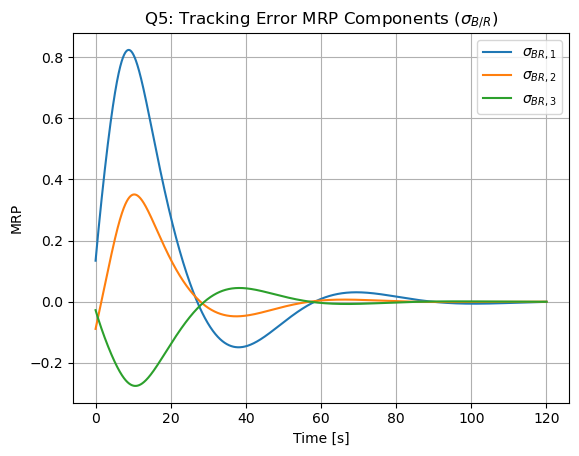

In [24]:
plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_{BR,1}$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_{BR,2}$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Tracking Error MRP Components ($\\sigma_{B/R}$)")
plt.legend()
plt.show()


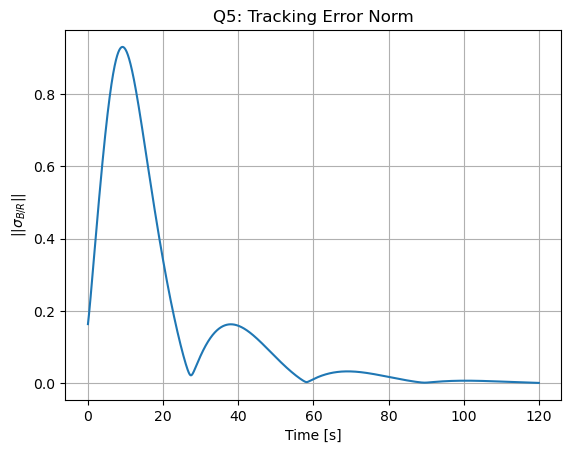

In [25]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma_BR, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma_{B/R}||$")
plt.title("Q5: Tracking Error Norm")
plt.show()


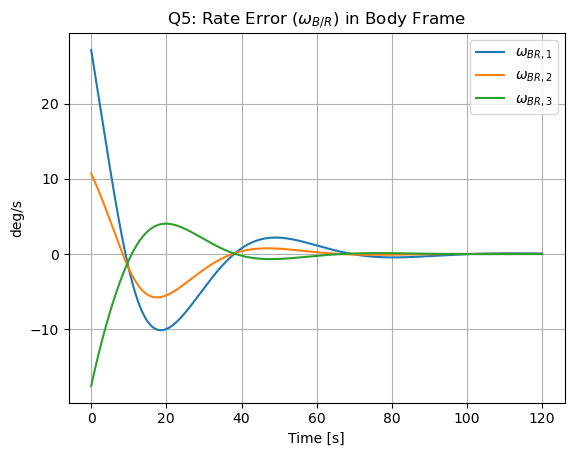

In [26]:
plt.figure()
plt.plot(t, omega_BR_deg[:, 0], label=r'$\omega_{BR,1}$')
plt.plot(t, omega_BR_deg[:, 1], label=r'$\omega_{BR,2}$')
plt.plot(t, omega_BR_deg[:, 2], label=r'$\omega_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Rate Error ($\\omega_{B/R}$) in Body Frame")
plt.legend()
plt.show()


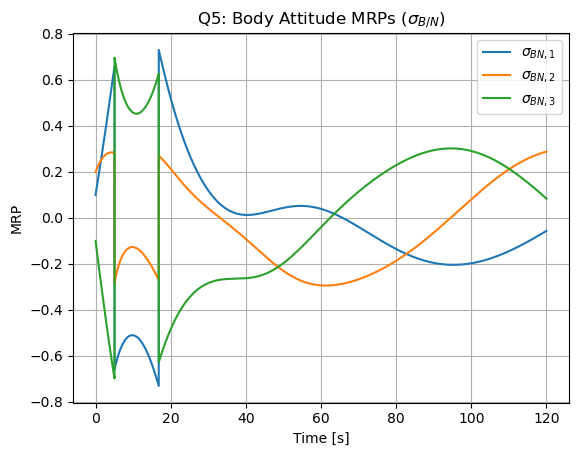

In [27]:
plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_{BN,1}$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_{BN,2}$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Body Attitude MRPs ($\\sigma_{B/N}$)")
plt.legend()
plt.show()


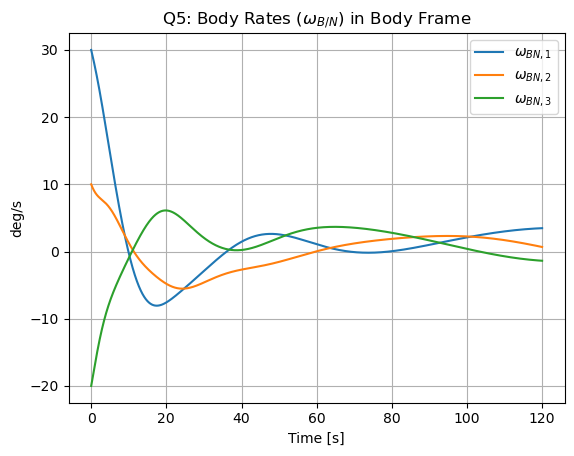

In [28]:
plt.figure()
plt.plot(t, omega_BN_deg[:, 0], label=r'$\omega_{BN,1}$')
plt.plot(t, omega_BN_deg[:, 1], label=r'$\omega_{BN,2}$')
plt.plot(t, omega_BN_deg[:, 2], label=r'$\omega_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Body Rates ($\\omega_{B/N}$) in Body Frame")
plt.legend()
plt.show()


In [29]:
dt = q5_sim_result["params"]["dt"]
idx_40 = int(round(40.0 / dt))
sig40 = float(np.linalg.norm(sigma_BR[idx_40]))
print(f"||sigma_B/R|| at t=40 s = {sig40:.15f}")

||sigma_B/R|| at t=40 s = 0.158822326291065
